In [2]:
import csv
from datetime import datetime
import time
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.stats import weightedtau, kendalltau
from scipy.stats import norm
from scipy.linalg import null_space

import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs
import pandas as pd
from pprint import pprint
from copy import deepcopy

import trueskill
import math


# First, parse game data

In [3]:
dt_str = '%d %B %Y %H:%M:%S'

dt_lim = datetime.strptime('06 August 2004 18:13:50', dt_str) #first game in HeadToHead

players = set()

# each entry is a tuple ([list of players], [list of scores])
matches = []

# needed for iteration
cur_game = -1
cur_players = []
cur_scores = []

# also, filter out all games where every player has no score!
with open('/Users/andy/Desktop/7332finalproj/hypergraph-halo-ranking/FreeForAll.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        date = datetime.strptime(row[0], dt_str)
        score = int(row[6])
        if date < dt_lim:
            game = int(row[1])
            player = row[4]
            score = int(row[6])
            
            # next, decide if this row is from the same match
            # as the last row, or a different match
            if game == cur_game:
                cur_players.append(player)
                cur_scores.append(score)
            else:
                if cur_game > 0 and np.sum(np.abs(cur_scores)):
                    # append cur_players, cur_scores to matches
                    matches.append((cur_players, cur_scores))
                    # add cur_players to players
                    players.update(cur_players)

                # reset cur_game, cur_players, cur_scores
                cur_game = game
                cur_players = [player]
                cur_scores = [score]
        else:
            break

players=list(players) # list of players

# Helper function for computing PageRank rankings

In [4]:
##################################################
# COMPUTE PAGERANK
##################################################

# given probability transition matrix P
# where P_{v,w} = Prob(w -> v)
# find pagerank scores with restart probability r
def compute_pr(P, r, n, eps=1e-8):
    x = np.ones(n) / n*1.0
    flag = True
    t=0
    while flag:
        x_new = (1-r)*P*x
        x_new = x_new + np.ones(n) * r / n
        diff = np.linalg.norm(x_new - x)
        if np.linalg.norm(x_new - x,ord=1) < eps and t > 100:
            flag = False
        t=t+1
        x = x_new
    return x

# Create hypergraph rankings

Rankings are a |V| x 1 vector, where the v-th entry is the PageRank score (or TrueSkill rating)  of vertex v

In [5]:
pi_list = matches
universe = np.array(list(players))
# first create these matrices
# R = |E| x |V|, R(e, v) = lambda_e(v)
# W = |V| x |E|, W(v, e) = w(e) 1(v in e)
    
m = len(pi_list) # number of hyperedges
n = len(universe) # number of items to be ranked 
R = np.zeros([m, n])
W = np.zeros([n, m])

for i in range(len(pi_list)):
    pi, scores = pi_list[i]
    if len(pi) > 1:   
        for j in range(len(pi)):
            v = pi[j]
            v = np.where(universe == v)[0][0] #equivalent to universe.index(v) but for np arrays
            R[i, v] = np.exp(scores[j])
            W[v,i] = (np.std(scores) + 1.0)
        R[i, :] = R[i,:] / sum(R[i,:])

# first, normalize W
Wnorm=W/W.sum(axis=1)[:,None]
Ws = sparse.csr_matrix(Wnorm)
Rs = sparse.csr_matrix(R)

# create prob trans matrices
P = np.transpose(Ws.dot(Rs))

# create rankings
r=0.40
rankings_hg = compute_pr(P, r, n, eps=1e-8).flatten()

# Create G^H, MC3 rankings

## G^H rankings

In [6]:
# Create matrix A, where A_{u,v} is given in Eq 10
def compute_gh_weights(R, W, P):
    E, V = R.shape
    A = np.zeros([V,V]) # to return
    
    # first, create edge weight vector
    WE = np.zeros(E)
    # for each edge, find first non-zero value that is >0
    for e in range(E):
        WE[e] = W[np.where(W[:,e] > 0)[0],e][0]
    
    # iterate over edges, add w(e) * gam_e(u) * gam_e(v) term
    # for each pair of vertices u,v \in e
    for e in range(E):
        nodes_in_e = np.nonzero(R[e,:])[0]
        for u in nodes_in_e:
            for v in nodes_in_e:
                A[u,v] += WE[e] * R[e,u] * R[e,v]
    return A

# create A, then find pagerank scores of random walk on A

# get probability transition matrix
A=compute_gh_weights(R, W, P)
P = A/A.sum(axis=1)[:,None]
P=P.T 
P = sparse.csr_matrix(P)

# compute pagerank scores
r=0.40
rankings_gh = compute_pr(P, r, n, eps=1e-8).flatten()

In [ ]:
free_for_all_data = pd.read_csv('/Users/andy/Desktop/7332finalproj/hypergraph-halo-ranking/FreeForAll.csv')

# EIGEN

In [8]:
def compute_eigenvector_centrality(A, n, eps=1e-8, max_iter=1000):
    """
    Compute Eigenvector Centrality from an adjacency matrix.
    Args:
    - A: Adjacency matrix.
    - n: Number of nodes.
    - eps: Convergence threshold.
    - max_iter: Maximum number of iterations.
    Returns:
    - Eigenvector Centrality scores for all nodes.
    """
    x = np.ones(n) / n  # init scores
    for _ in range(max_iter):
        x_new = A.dot(x)
        x_new /= np.linalg.norm(x_new, ord=1)
        if np.linalg.norm(x_new - x, ord=1) < eps:
            break
        x = x_new
    return x

def compute_eigenvector_from_ffa(free_for_all_data):
    """
    Compute Eigenvector Centrality using the Free-for-All dataset.
    Args:
    - free_for_all_data: DataFrame containing Free-for-All matches.
    Returns:
    - Eigenvector Centrality scores for all players.
    """
    players = free_for_all_data.iloc[:, 4].unique()  
    player_indices = {player: idx for idx, player in enumerate(players)}
    n = len(players)
    A = np.zeros((n, n)) 

    grouped = free_for_all_data.groupby(free_for_all_data.iloc[:, 1]) 
    for _, match_data in grouped:
        players_in_match = match_data.iloc[:, 4].values
        scores_in_match = match_data.iloc[:, 5].values
        for i in range(len(players_in_match)):
            for j in range(len(players_in_match)):
                if i != j:
                    A[player_indices[players_in_match[i]], player_indices[players_in_match[j]]] += scores_in_match[i]

    return compute_eigenvector_centrality(A, n)

eigenvector_rankings = compute_eigenvector_from_ffa(free_for_all_data)

## MC3 rankings

In [9]:
n = len(universe)

Pd = np.zeros([n, n]) # d for dwork

for i in universe:
    i_counts = np.zeros(n) # number of ways i can go to any other vertex
    i_deg = 0 #number of hyperedges where i can traverse to some other vertex

    i_index = np.where(universe == i)
    for pi, scores in pi_list:
        if i in pi and len(pi) > 1:
            pi_filtered = pi[pi.index(i)+1:] #everything ranked better than i

            # if i can use this hyperedge
            if len(pi_filtered) > 0:
                # essentially, for each j in pi_filtered
                # grab k=universe.index(j) and increment i_counts[k] by 1/len(pi)
                i_counts[np.where(np.isin(universe, pi_filtered))] += 1/len(pi)

            i_counts[i_index] += 1 - (len(pi_filtered) / len(pi))
            i_deg += 1
    if i_deg > 0:
        i_counts /= i_deg
    else:
        i_counts[i_index] = 1
    Pd[i_index,:] = i_counts

Pd = np.transpose(Pd) # since we're using column vectors
Pd = sparse.csr_matrix(Pd)

# create MC3 rankings
r=0.40

rankings_mc3 = compute_pr(Pd, r, n, eps=1e-8).flatten()

# Create TrueSkill rankings

In [10]:
# simulate the change in TrueSkill ratings when a Free-For-All match is played
def play_match(match, ts_ranking):
    p, s = match
    cur_ranks = []
    for player in p:
        if player in ts_ranking:
            cur_ranks.append([ts_ranking[player]])
        else:
            cur_ranks.append([trueskill.Rating()])
    # lower rank = better player for trueskill.rate function, so we turn scores into -1*scores
    match_res = trueskill.rate(cur_ranks, ranks=[-1*i for i in s])
    for i in range(len(p)):
        player = p[i]
        ts_ranking[player] = match_res[i][0]

In [11]:
trueskill_rankings={} # dict mapping player -> TrueSkill rating object

# simulate all matches being played, in order
for match in matches:
    play_match(match, trueskill_rankings)

rankings_ts = [trueskill_rankings[player].mu for player in players] # deterministic TrueSkill ratings list

# hybrid model

In [12]:
# not sure if this conts as rank agg funciton
def compute_hybrid_ranking(rankings, weights):
    """
    Compute hybrid rankings by combining weighted scores.
    Args:
    - rankings: Dictionary with keys as method names and values as ranking lists.
    - weights: Dictionary with weights for each method.
    Returns:
    - hybrid_scores: Combined hybrid scores for each player.
    """
    n = len(next(iter(rankings.values())))  
    hybrid_scores = np.zeros(n)
    for method, scores in rankings.items():
        hybrid_scores += weights[method] * np.array(scores)
    return hybrid_scores

# weights calculated by those commented chunk below
weights = {
    "Hypergraph": 0.15,
    "G^H": 0.25,
    "MC3": 0.25,
    "TrueSkill": 0.25
}


rankings_combined = {
    "Hypergraph": rankings_hg,
    "G^H": rankings_gh,
    "MC3": rankings_mc3,
    "TrueSkill": rankings_ts
}
rankings_hybrid = compute_hybrid_ranking(rankings_combined, weights)

# Elo

In [37]:
def update_elo(player_elo, winner, loser, k=32):
    """
    Update Elo ratings for a winner and a loser.
    Args:
    - player_elo: Dictionary of player Elo ratings.
    - winner: ID of the winner.
    - loser: ID of the loser.
    - k: K-factor for adjusting Elo ratings.
    """
    r1 = 10 ** (player_elo[winner] / 400)
    r2 = 10 ** (player_elo[loser] / 400)
    e1 = r1 / (r1 + r2)
    e2 = r2 / (r1 + r2)
    player_elo[winner] += k * (1 - e1)
    player_elo[loser] += k * (0 - e2)

def compute_elo_rankings(free_for_all_data):
    """
    Compute Elo rankings using the Free-for-All dataset.
    Args:
    - free_for_all_data: DataFrame containing Free-for-All matches.
    Returns:
    - Dictionary of Elo scores for all players.
    """
    player_elo = {}  # init Elo ratings
    grouped = free_for_all_data.groupby(free_for_all_data.iloc[:, 1])  
    for _, match_data in grouped:
        players = match_data.iloc[:, 4].values  #id
        scores = match_data.iloc[:, 5].values  # score
        for i in range(len(players)):
            for j in range(i + 1, len(players)):
                if scores[i] != scores[j]:  # remove ties
                    winner = players[i] if scores[i] > scores[j] else players[j]
                    loser = players[j] if scores[i] > scores[j] else players[i]
                    if winner not in player_elo:
                        player_elo[winner] = 1000
                    if loser not in player_elo:
                        player_elo[loser] = 1000
                    update_elo(player_elo, winner, loser)
    return player_elo

elo_rankings_dict = compute_elo_rankings(free_for_all_data)
elo_rankings2 = [elo_rankings_dict[player] if player in elo_rankings_dict else 0 for player in players]


# katz

In [45]:
def compute_katz_centrality(A, alpha, beta, n, eps=1e-8, max_iter=1000):
    """
    Compute Katz Centrality.
    A: Adjacency matrix
    alpha: Decay factor (must be less than 1 / max_eigenvalue)
    beta: Bias term (usually set to 1)
    """
    x = np.ones(n) * beta
    for _ in range(max_iter):
        x_new = alpha * A.dot(x) + beta
        if np.linalg.norm(x_new - x, ord=1) < eps:
            break
        x = x_new
    return x

# use adjacency matrix A from G^H
lambda_max = eigs(A, k=1, which='LM', return_eigenvectors=False)[0].real
alpha = 0.1 / lambda_max
beta = 1.0
rankings_katz = compute_katz_centrality(A, alpha, beta, len(players))

# eigenvector 

In [15]:
def compute_eigenvector_centrality(A, n):
    """
    Compute Eigenvector Centrality.
    A: Adjacency matrix
    """
    eigenvalues, eigenvectors = eigs(A, k=1, which='LR')
    centrality = eigenvectors[:, 0].real
    centrality = np.abs(centrality)  # remove negative values
    centrality /= centrality.sum()  # normalizaiton
    return centrality

rankings_eigenvector = compute_eigenvector_centrality(A, len(players))

# Glicko

In [ ]:
# # Glicko constants
# q = math.log(10) / 400  # scaling factor
# g = lambda RD: 1 / math.sqrt(1 + (3 * (q ** 2) * (RD ** 2)) / (math.pi ** 2))  # rd scaling factor, math.pi^2 = 9.8696
# E = lambda R1, R2, RD2: 1 / (1 + 10 ** (-g(RD2) * (R1 - R2) / 400))  # e_val

# def update_glicko(player_ratings, matches, tau=0.5):
#     """
#     Update Glicko ratings for players based on match outcomes.
#     Args:
#     - player_ratings: Dictionary of player ratings as (R, RD, volatility).
#     - matches: List of matches as (player1, player2, outcome), where:
#                - player1, player2 are IDs
#                - outcome: 1 if player1 wins, 0 if player2 wins
#     - tau: System constant for volatility adjustment (default 0.5).
#     Returns:
#     - Updated player ratings.
#     """
#     for player1, player2, outcome in matches:
#         if player1 not in player_ratings:
#             player_ratings[player1] = (1500, 350, 0.06)  # these are default values
#         if player2 not in player_ratings:
#             player_ratings[player2] = (1500, 350, 0.06)

#         R1, RD1, sigma1 = player_ratings[player1]
#         R2, RD2, sigma2 = player_ratings[player2]

#         # convert ratings to Glicko scale
#         mu1, mu2 = R1 / 173.7178, R2 / 173.7178
#         phi1, phi2 = RD1 / 173.7178, RD2 / 173.7178

       
#         g_phi2 = g(phi2)
#         E_mu1_mu2 = 1 / (1 + math.exp(-g_phi2 * (mu1 - mu2)))

#         # update rating deviation
#         v = (g_phi2 ** 2) * E_mu1_mu2 * (1 - E_mu1_mu2)
#         delta = g_phi2 * (outcome - E_mu1_mu2) / v
#         phi_prime = 1 / math.sqrt(1 / (phi1 ** 2) + 1 / v)
#         mu_prime = mu1 + phi_prime ** 2 * g_phi2 * (outcome - E_mu1_mu2)

#         # update volatility
#         sigma_prime = sigma1 

#         # change back to original scale
#         R_prime = mu_prime * 173.7178
#         RD_prime = phi_prime * 173.7178

#         player_ratings[player1] = (R_prime, RD_prime, sigma_prime)

#     return player_ratings

# def compute_glicko_rankings(free_for_all_data):
#     """
#     Compute Glicko rankings using the Free-for-All dataset.
#     Args:
#     - free_for_all_data: DataFrame containing Free-for-All matches.
#     Returns:
#     - Dictionary of Glicko scores for all players.
#     """
#     matches = []
#     grouped = free_for_all_data.groupby(free_for_all_data.iloc[:, 1])  
#     for _, match_data in grouped:
#         players = match_data.iloc[:, 4].values  # id
#         scores = match_data.iloc[:, 5].values  # score
#         for i in range(len(players)):
#             for j in range(i + 1, len(players)):
#                 if scores[i] != scores[j]:  # remove ties
#                     outcome = 1 if scores[i] > scores[j] else 0
#                     matches.append((players[i], players[j], outcome))
#     # init player ratings
#     player_ratings = {}
#     player_ratings = update_glicko(player_ratings, matches)
#     return {player: rating[0] for player, rating in player_ratings.items()}  # ratings only


# glicko_rankings_dict = compute_glicko_rankings(free_for_all_data)
# glicko_rankings = [glicko_rankings_dict[player] if player in glicko_rankings_dict else 0 for player in players]

In [36]:

from tqdm import tqdm  # Import tqdm for progress bars

# Glicko constants
q = math.log(10) / 400  # Scaling factor
g = lambda RD: 1 / math.sqrt(1 + (3 * (q ** 2) * (RD ** 2)) / (math.pi ** 2))
E = lambda R1, R2, RD2: 1 / (1 + 10 ** (-g(RD2) * (R1 - R2) / 400))



def update_sigma(sigma, delta, RD, v, tau=0.5):
    """
    Fast approximate update for volatility (sigma) in the Glicko-2 system.
    Args:
    - sigma: Current volatility.
    - delta: Estimated improvement in skill.
    - RD: Rating deviation.
    - v: Variance of match outcomes.
    - tau: System constant for volatility adjustment (default 0.5).
    Returns:
    - Updated volatility (sigma').
    """
    delta_squared = delta ** 2
    sigma_squared = sigma ** 2
    rd_squared = RD ** 2

    # Simplify: Avoid invalid scaling factors
    numerator = max(delta_squared - rd_squared - v, 0)  # Ensure non-negative
    denominator = max(v + tau, 1e-6)  # Avoid division by zero

    scaling_factor = math.sqrt(numerator / denominator) if numerator > 0 else 0
    sigma_prime = sigma * (1 + scaling_factor)

    # Ensure stability for edge cases
    if sigma_prime < 1e-4:
        sigma_prime = 1e-4  # Minimum volatility to prevent degenerate ratings

    return sigma_prime


def update_glicko(player_ratings, matches, tau=0.5):
    """
    Update Glicko ratings for players based on match outcomes.
    """
    for player1, player2, outcome in tqdm(matches, desc="Updating Glicko Ratings", unit="match"):
        if player1 not in player_ratings:
            player_ratings[player1] = (1500, 350, 0.06)  # Default values
        if player2 not in player_ratings:
            player_ratings[player2] = (1500, 350, 0.06)

        R1, RD1, sigma1 = player_ratings[player1]
        R2, RD2, sigma2 = player_ratings[player2]

        # Convert ratings to Glicko scale
        mu1, mu2 = R1 / 173.7178, R2 / 173.7178
        phi1, phi2 = RD1 / 173.7178, RD2 / 173.7178

        g_phi2 = g(phi2)
        E_mu1_mu2 = 1 / (1 + math.exp(-g_phi2 * (mu1 - mu2)))

        # Compute variance (v) and delta
        v = 1 / (g_phi2 ** 2 * E_mu1_mu2 * (1 - E_mu1_mu2))
        delta = g_phi2 * (outcome - E_mu1_mu2) / v

        # Update volatility (sigma)
        sigma_prime = update_sigma(sigma1, delta, phi1, v, tau)

        # Update RD (phi')
        phi_prime = 1 / math.sqrt(1 / (phi1 ** 2) + 1 / v)

        # Update rating (mu')
        mu_prime = mu1 + phi_prime ** 2 * g_phi2 * (outcome - E_mu1_mu2)

        # Convert back to original scale
        R_prime = mu_prime * 173.7178
        RD_prime = phi_prime * 173.7178

        player_ratings[player1] = (R_prime, RD_prime, sigma_prime)

    return player_ratings


def compute_glicko_rankings(free_for_all_data):
    """
    Compute Glicko rankings using the Free-for-All dataset.
    """
    matches = []
    grouped = free_for_all_data.groupby(free_for_all_data.iloc[:, 1])
    for _, match_data in tqdm(grouped, desc="Processing Matches", unit="group"):
        players = match_data.iloc[:, 4].values  # id
        scores = match_data.iloc[:, 5].values  # score
        for i in range(len(players)):
            for j in range(i + 1, len(players)):
                if scores[i] != scores[j]:  # remove ties
                    outcome = 1 if scores[i] > scores[j] else 0
                    matches.append((players[i], players[j], outcome))

    # Initialize player ratings
    player_ratings = {}
    player_ratings = update_glicko(player_ratings, matches)
    return {player: rating[0] for player, rating in player_ratings.items()}  # ratings only


# Compute Glicko rankings
glicko_rankings_dict = compute_glicko_rankings(free_for_all_data)
glicko_rankings2 = [glicko_rankings_dict[player] if player in glicko_rankings_dict else 0 for player in players]

Updating Glicko Ratings: 100%|██████████| 655957/655957 [00:01<00:00, 364353.34match/s]


# Evaluate 4 rankings

In [17]:
# Evaluating a 1v1 game with a deterministic ranking of players
# INPUTS:
# game_players: list of players in the match
# game_scores: list of scores in the match (corresponding to game_players)
# all_players: list of all players in all matches
# ranks: one of the 4 rankings computed above

# OUTPUT: 
# can_eval: False if game ends in tie, True otherwise (we ignore tie games)
# res: 1 if ranks correctly predicts the match, 0 if not
def eval_game_h2h(game_players, game_scores, all_players, ranks):
    players_ranked_prev = [player for player in game_players if player in all_players]
    if len(players_ranked_prev) == 2:
        # get scores for players previously ranked
        scores_prev = [game_scores[game_players.index(player)] for player in players_ranked_prev]
        ranks_prev = [ranks[all_players.index(player)] for player in players_ranked_prev]

        # make sure there isn't a tie
        if scores_prev[0] != scores_prev[1]:
            can_eval = True
            
            # check if ranked correctly
            if sum(np.argsort(scores_prev) == np.argsort(ranks_prev)) == 2:
                res = True
            else:
                res = False
        else:
            can_eval = False
            res = False
    else:
        can_eval = False
        res = False
    return (can_eval, int(res))

# Evaluating a 1v1 game with TS probabilistic procedure. Same inputs/outputs as above.
def eval_game_h2h_trueskill(game_players, game_scores, all_players, ts_ranking):
    players_ranked_prev = [player for player in game_players if player in all_players]
    if len(players_ranked_prev) == 2:
        # get scores for players previously ranked
        scores_prev = [game_scores[game_players.index(player)] for player in players_ranked_prev]
        ts_ranks_prev = [ts_ranking[player] for player in players_ranked_prev]

        # make sure there isn't a tie
        if scores_prev[0] != scores_prev[1]:
            can_eval = True
            
            # compare rating distributions between two players 
            # (for simplicity, do not consider draw probability)
            mu0, sigma0 = ts_ranks_prev[0]
            mu1, sigma1 = ts_ranks_prev[1]
            p = 1 - norm.cdf(-1.0 * (mu0 - mu1) / (sigma0**2 + sigma1**2))
            if (p > 0.5 and scores_prev[0] > scores_prev[1]) or (p < 0.5 and scores_prev[0] < scores_prev[1]):
                res = True
            else:
                res = False

        else:
            can_eval = False
            res = False
    else:
        can_eval = False
        res = False
    return (can_eval, res)

In [17]:
# from scipy.optimize import minimize
# import numpy as np

# # Define a function to compute hybrid rankings with given weights
# def compute_hybrid_ranking(weights, rankings):
#     """
#     Compute hybrid rankings by combining weighted scores.
#     Args:
#     - weights: Array of weights for each ranking method.
#     - rankings: Dictionary with keys as method names and values as ranking lists.
#     Returns:
#     - hybrid_scores: Combined hybrid scores for each player.
#     """
#     n = len(next(iter(rankings.values())))  # Number of players
#     hybrid_scores = np.zeros(n)
#     for i, (method, scores) in enumerate(rankings.items()):
#         hybrid_scores += weights[i] * np.array(scores)
#     return hybrid_scores

# # Define an objective function to minimize (negative accuracy for maximization)
# def objective_function(weights, rankings, players, eval_func, games):
#     """
#     Objective function to minimize negative prediction accuracy.
#     Args:
#     - weights: Array of weights for each ranking method.
#     - rankings: Dictionary of rankings from different methods.
#     - players: List of all players.
#     - eval_func: Evaluation function to compute prediction accuracy.
#     - games: List of games with player and score data.
#     Returns:
#     - Negative accuracy (to maximize accuracy by minimizing this value).
#     """
#     weights = np.array(weights) / np.sum(weights)  # Normalize weights
#     hybrid_scores = compute_hybrid_ranking(weights, rankings)
#     correct_predictions = 0
#     total_games = 0

#     for game_players, game_scores in games:
#         can_eval, result = eval_func(game_players, game_scores, players, hybrid_scores)
#         if can_eval:
#             correct_predictions += result
#             total_games += 1

#     accuracy = correct_predictions / total_games if total_games > 0 else 0
#     return -accuracy  # Negate accuracy for minimization

# # Example usage
# rankings_combined = {
#     "Hypergraph": rankings_hg,
#     "G^H": rankings_gh,
#     "MC3": rankings_mc3,
#     "TrueSkill": rankings_ts
# }


# # Initialize variables to hold all players and scores from the dataset
# all_game_players = []
# all_game_scores = []

# # Populate all_game_players and all_game_scores during game parsing
# with open('/Users/andy/Desktop/7332finalproj/hypergraph-halo-ranking/HeadToHead.csv') as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     cur_game = -1
#     cur_players = []
#     cur_scores = []

#     for row in csv_reader:
#         game = int(row[1])
#         player = row[4]
#         score = int(row[6])

#         if game == cur_game:
#             cur_players.append(player)
#             cur_scores.append(score)
#         else:
#             if cur_game > 0 and np.sum(np.abs(cur_scores)) > 0:
#                 # Add completed game's players and scores
#                 all_game_players.append(cur_players)
#                 all_game_scores.append(cur_scores)

#             # Reset for the new game
#             cur_game = game
#             cur_players = [player]
#             cur_scores = [score]

#     # Add the last game
#     if np.sum(np.abs(cur_scores)) > 0:
#         all_game_players.append(cur_players)
#         all_game_scores.append(cur_scores)

# # Create the games list
# games = [(cur_players, cur_scores) for cur_players, cur_scores in zip(all_game_players, all_game_scores)]
# # Define players if missing
# players = list(set(player for game in all_game_players for player in game))

# # Initial weights
# initial_weights = np.ones(len(rankings_combined))

# # Minimize the negative accuracy to find the best weights
# result = minimize(
#     objective_function,
#     initial_weights,
#     args=(rankings_combined, players, eval_game_h2h, games),
#     method='SLSQP',
#     bounds=[(0, 1)] * len(rankings_combined),  # Ensure weights are between 0 and 1
#     constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Weights sum to 1
# )

# # Get the optimal weights
# optimal_weights = result.x
# print(f"Optimal weights: {optimal_weights}")

# # Compute final hybrid rankings with optimal weights
# rankings_hybrid = compute_hybrid_ranking(optimal_weights, rankings_combined)

Go through each game and use each of the different rankings to predict the winner. Compare to actual winner.

In [ ]:
cur_game = -1
cur_players = []
cur_scores = []

results_hg=[]
results_gh=[]
results_mc3=[]
results_ts=[]
results_ts_prob=[]
results_hybrid = []
results_elo = []
results_katz = []
results_eigenvector = []
results_glicko = []

with open('/Users/andy/Desktop/7332finalproj/hypergraph-halo-ranking/HeadToHead.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        game = int(row[1])
        player = row[4]
        score = int(row[6])

        # next, decide if this row is from the same match
        # as the last row, or a different match
        if game == cur_game:
            cur_players.append(player)
            cur_scores.append(score)
        else:
            if cur_game > 0 and np.sum(np.abs(cur_scores)) > 0:
                # evaluate game
               # Evaluate game
                can_eval, elo_match_res = eval_game_h2h(cur_players, cur_scores, players, elo_rankings2)
                can_eval, katz_match_res = eval_game_h2h(cur_players, cur_scores, players,rankings_katz)
                can_eval, eigenvector_match_res = eval_game_h2h(cur_players, cur_scores, players, rankings_eigenvector)

                can_eval, hybrid_match_res = eval_game_h2h(cur_players, cur_scores, players, rankings_hybrid)
                can_eval, hg_match_res = eval_game_h2h(cur_players, cur_scores, players, rankings_hg)
                can_eval, gh_match_res = eval_game_h2h(cur_players, cur_scores, players, rankings_gh)
                can_eval, mc3_match_res = eval_game_h2h(cur_players, cur_scores, players, rankings_mc3)
                can_eval, ts_match_res = eval_game_h2h(cur_players, cur_scores, players, rankings_ts)
                can_eval, ts_prob_match_res = eval_game_h2h_trueskill(cur_players, cur_scores, players, trueskill_rankings)
                can_eval, glicko_match_res = eval_game_h2h(cur_players, cur_scores, players, glicko_rankings2)
                if can_eval:
                    results_elo.append(elo_match_res)
                    results_katz.append(katz_match_res)
                    results_eigenvector.append(eigenvector_match_res)
                    results_hg.append(hg_match_res)
                    results_gh.append(gh_match_res)
                    results_mc3.append(mc3_match_res)
                    results_ts.append(ts_match_res)
                    results_hybrid.append(hybrid_match_res)
                    results_ts_prob.append(ts_prob_match_res)
                    results_glicko.append(glicko_match_res)

            # reset cur_game, cur_players, cur_scores
            cur_game = game
            cur_players = [player]
            cur_scores = [score]

num_games = len(results_hg)



Hypergraph accuracy: 0.7113685450618495
Glicko accuracy: 0.4984018976710308
Clique Graph accuracy: 0.6112311015118791
Dwork MC3 accuracy: 0.5293540153151384
TrueSkill accuracy: 0.7345376006283134
TrueSkill accuracy, probabilistic decision procedure: 0.7345376006283134
Elo accuracy: 0.49518947575103084
Katz Centrality accuracy: 0.702729236206558
Eigenvector Centrality accuracy: 0.6748478303553898


In [ ]:
# Print accuracy for all ranking methods
print('Hypergraph accuracy: {}'.format(sum(results_hg) * 1.0 / num_games))
print('Glicko accuracy: {}'.format((sum(results_glicko) * 1.0 / num_games)))
print('Clique Graph accuracy: {}'.format(sum(results_gh) * 1.0 / num_games))
print('Dwork MC3 accuracy: {}'.format(sum(results_mc3) * 1.0 / num_games))
print('TrueSkill accuracy: {}'.format(sum(results_ts) * 1.0 / num_games))
#print('Hybrid accuracy: {}'.format(sum(results_hybrid) * 1.0 / num_games))
# print('TrueSkill accuracy, probabilistic decision procedure: {}'.format(sum(results_ts_prob) * 1.0 / num_games))
print('Elo accuracy: {}'.format(sum(results_elo) * 1.0 / num_games))
print('Katz Centrality accuracy: {}'.format(sum(results_katz) * 1.0 / num_games))
print('Eigenvector Centrality accuracy: {}'.format(sum(results_eigenvector) * 1.0 / num_games))

Hypergraph accuracy: 0.7113685450618495
Glicko accuracy: 0.5676405968510309
Clique Graph accuracy: 0.6112311015118791
Dwork MC3 accuracy: 0.5293540153151384
TrueSkill accuracy: 0.7345376006283134
Elo accuracy: 0.49518947575103084
Katz Centrality accuracy: 0.702729236206558
Eigenvector Centrality accuracy: 0.6748478303553898


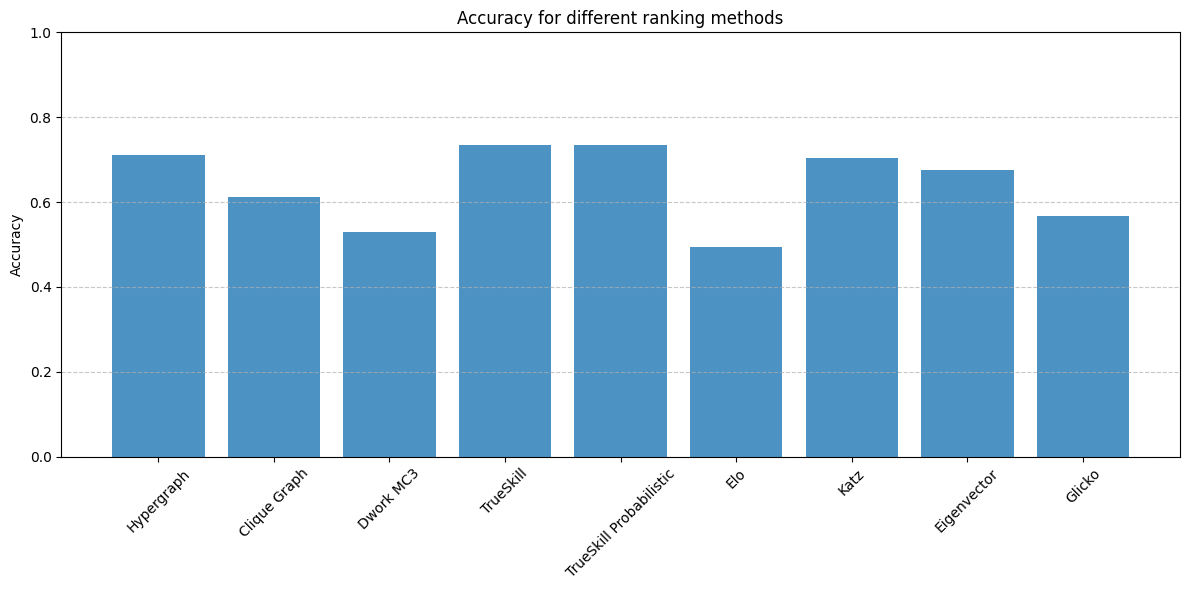

In [ ]:
# Accuracy results (replace with actual values after running your script)
methods = [
    "Hypergraph", "Clique Graph", "Dwork MC3", "TrueSkill", 
"TrueSkill Probabilistic", "Elo", "Katz", "Eigenvector", "Glicko"
]
accuracies = [
    sum(results_hg) / num_games, sum(results_gh) / num_games, 
    sum(results_mc3) / num_games, sum(results_ts) / num_games, 
    sum(results_ts_prob) / num_games,
    sum(results_elo) / num_games, sum(results_katz) / num_games, 
    sum(results_eigenvector) / num_games, sum(results_glicko) / num_games
]

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(methods, accuracies, alpha=0.8)
plt.ylabel('Accuracy')
plt.title('Accuracy for different ranking methods')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Differences between hypergraph and TS rankings

We compute the percentage of matches which HG/TS differ on

In [ ]:
hg_only=0
ts_only=0
katz_only = 0
eigen_only = 0
all=0
for i in range(num_games):
    if results_hg[i] > 0 and results_ts[i] > 0 and results_katz[i] > 0 and results_eigenvector[i] > 0:
        all += 1
    elif results_hg[i] > 0:
        hg_only += 1
    elif results_ts[i] > 0:
        ts_only += 1
    elif results_katz[i] > 0:
        katz_only += 1
    elif results_eigenvector[i] > 0:
        eigen_only += 1
print('% of Matches predicted correctly by Katz, EV, TrueSkill and hypergraph: {}'.format(all/ num_games))
print('% of Matches predicted correctly by only TrueSkill: {}'.format(ts_only / num_games))
print('% of Matches predicted correctly by only hypergraph: {}'.format(hg_only / num_games))
print('% of Matches predicted correctly by only Katz: {}'.format(katz_only / num_games))
print('% of Matches predicted correctly by only Eigenvector: {}'.format(eigen_only / num_games))


% of Matches predicted correctly by Katz, EV, TrueSkill and hypergraph: 0.5295503632436678
% of Matches predicted correctly by only TrueSkill: 0.11250736304731986
% of Matches predicted correctly by only hypergraph: 0.18181818181818182
% of Matches predicted correctly by only Katz: 0.015511486353818967
% of Matches predicted correctly by only Eigenvector: 0.0196347928529354


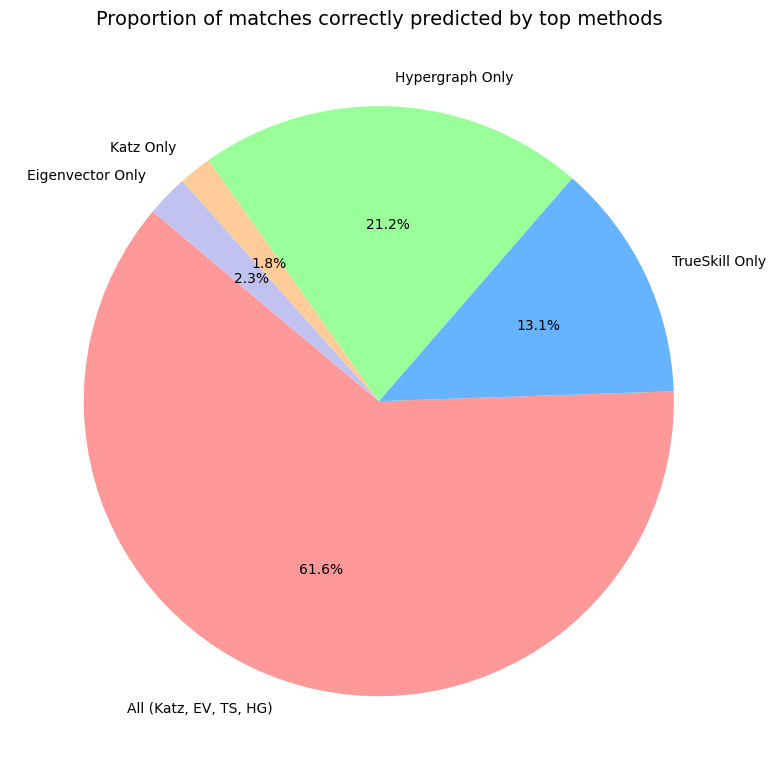

In [65]:
categories = [
    "All (Katz, EV, TS, HG)",
    "TrueSkill Only",
    "Hypergraph Only",
    "Katz Only",
    "Eigenvector Only"
]
values = [
    all / num_games,
    ts_only / num_games,
    hg_only / num_games,
    katz_only / num_games,
    eigen_only / num_games
]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    values,
    labels=categories,
    autopct="%1.1f%%",
    startangle=140,
    colors=["#ff9999", "#66b3ff", "#99ff99", "#ffcc99", "#c2c2f0"]
)

# Add a title
plt.title("Proportion of matches correctly predicted by top methods", fontsize=14)

# Show the pie chart
plt.tight_layout()
plt.show()